# Predicting Whether an Airbnb Listing Is for Business Use

**Names**: Arman Soni, Charles Ma, Arad Prashad Shah, Phillip Li  
**Course**: STAT 301  
**Date**: 2nd April, 2025

# Introduction

Airbnb has become a dominant force in the short‐term rental market, offering travelers unique accommodation options that vary widely in price, location, property type, and host interaction. While it has historically catered to leisure travelers seeking authentic local experiences, Airbnb has also seen a rising number of **business travelers**, prompting listings to cater specifically to corporate needs—often emphasizing convenience, reliability, and proximity to key commercial areas. Recent studies have underscored these shifts: Jang et al. (2019) show that factors like location and smooth booking processes are critical to business guests, whereas Kirchner and Pohl (2024) highlight the increasing “professionalization” of Airbnb, with hosts operating multiple properties more like a formal business.

Against this backdrop, our central **research question** is:  
> **“Can we predict whether an Airbnb listing is for business purposes based on its features?”**  

This question will be addressed using a dataset of Airbnb listings from **Amsterdam**, **Athens**, and **Berlin**—three European cities representing different regulatory, cultural, and tourism environments. The dataset includes a range of variables (e.g., price, room type, cleanliness rating, distance from city center), as well as indicators like “biz” (a flag for business‐designated listings). By examining these features, we aim to:  
1. Identify which listing characteristics are most predictive of “business use.”  
2. Assess the importance of location‐based and service‐based factors that may shape business travelers’ preferences.

In the sections that follow, we detail the **methodology** used to develop a predictive model, present **results** on the key features driving business listing classification, and discuss **implications** for hosts, platform operators, and urban policymakers.


## (2) Methods and Results

### (a) Exploratory Data Analysis (EDA)

**Data Loading, Cleaning, and Wrangling**  
Below, we demonstrate how the data are read and combined into a single dataset, followed by basic cleaning and transformations.



In [1]:
# Load required libraries
library(tidyverse)
library(repr)
library(broom)
library(ggplot2)
library(glmnet)
library(pROC)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is mask

In [2]:
# Set display options
options(repr.plot.width = 8, repr.plot.height = 6)

# 1) Read datasets from GitHub raw URLs
dat_amsterdam_weekdays <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/amsterdam_weekdays.csv") %>%
  mutate(city = "Amsterdam", weekend = "No")

dat_amsterdam_weekends <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/amsterdam_weekends.csv") %>%
  mutate(city = "Amsterdam", weekend = "Yes")

dat_athens_weekdays <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/athens_weekdays.csv") %>%
  mutate(city = "Athens", weekend = "No")

dat_athens_weekends <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/athens_weekends.csv") %>%
  mutate(city = "Athens", weekend = "Yes")

dat_berlin_weekdays <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/berlin_weekdays.csv") %>%
  mutate(city = "Berlin", weekend = "No")

dat_berlin_weekends <- read.csv("https://raw.githubusercontent.com/ArmanSoni/airbnb_datasets/main/berlin_weekends.csv") %>%
  mutate(city = "Berlin", weekend = "Yes")

# Combine all datasets
dat_combined <- bind_rows(
  dat_amsterdam_weekdays,
  dat_amsterdam_weekends,
  dat_athens_weekdays,
  dat_athens_weekends,
  dat_berlin_weekdays,
  dat_berlin_weekends
)

# Convert select variables to factors
dat_combined <- dat_combined %>%
  mutate(
    city    = factor(city),
    weekend = factor(weekend)
  ) %>%
  rename(ID = X)

# Display structure of the combined dataset
head(dat_combined)
str(dat_combined)

num_obs  <- nrow(dat_combined)
num_vars <- ncol(dat_combined)

cat("Number of observations:", num_obs, "\n")
cat("Number of variables:", num_vars, "\n")


ID realSum  room_type    room_shared room_private person_capacity
1 0  194.0337 Private room False       True         2              
2 1  344.2458 Private room False       True         4              
3 2  264.1014 Private room False       True         2              
4 3  433.5294 Private room False       True         4              
5 4  485.5529 Private room False       True         2              
6 5  552.8086 Private room False       True         3              
  host_is_superhost multi biz cleanliness_rating ⋯ dist      metro_dist
1 False             1     0   10                 ⋯ 5.0229638 2.5393800 
2 False             0     0    8                 ⋯ 0.4883893 0.2394039 
3 False             0     1    9                 ⋯ 5.7483119 3.6516213 
4 False             0     1    9                 ⋯ 0.3848620 0.4398761 
5 True              0     0   10                 ⋯ 0.5447382 0.3186926 
6 False             0     0    8                 ⋯ 2.1314201 1.9046682 
  attr_index attr_index_norm rest_index rest_index_norm lng     lat     
1  78.69038   4.166708        98.25390   6.846473       4.90569 52.41772
2 631.17638  33.421209       837.28076  58.342928       4.90005 52.37432
3  75.27588   3.985908        95.38695   6.646700       4.97512 52.36103
4 493.27253  26.119108       875.03310  60.973565       4.89417 52.37663
5 552.83032  29.272733       815.30574  56.811677       4.90051 52.37508
6 174.78896   9.255191       225.20166  15.692376       4.87699 52.38966
  city      weekend
1 Amsterdam No     
2 Amsterdam No     
3 Amsterdam No     
4 Amsterdam No     
5 Amsterdam No     
6 Amsterdam No

'data.frame':	9844 obs. of  22 variables:
 $ ID                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ realSum                   : num  194 344 264 434 486 ...
 $ room_type                 : chr  "Private room" "Private room" "Private room" "Private room" ...
 $ room_shared               : chr  "False" "False" "False" "False" ...
 $ room_private              : chr  "True" "True" "True" "True" ...
 $ person_capacity           : num  2 4 2 4 2 3 2 4 4 2 ...
 $ host_is_superhost         : chr  "False" "False" "False" "False" ...
 $ multi                     : int  1 0 0 0 0 0 0 0 0 1 ...
 $ biz                       : int  0 0 1 1 0 0 0 0 0 0 ...
 $ cleanliness_rating        : num  10 8 9 9 10 8 10 10 9 10 ...
 $ guest_satisfaction_overall: num  93 85 87 90 98 100 94 100 96 88 ...
 $ bedrooms                  : int  1 1 1 2 1 2 1 3 2 1 ...
 $ dist                      : num  5.023 0.488 5.748 0.385 0.545 ...
 $ metro_dist                : num  2.539 0.239 3.652 0.44 0.319 ...
 $ attr_in

**Commentary**  
- We see that **`dat_combined`** merges listings from Amsterdam, Athens, and Berlin, with **9,844** total rows and **22** columns.  
- Variables such as `city` and `weekend` are converted to factors.  
---

**Variable Dictionary**  
Below is a quick table describing each column’s data type.

In [3]:
df_variables <- tibble(
  Variable = names(dat_combined),
  Type     = sapply(dat_combined, class)
)
df_variables


Variable                   Type     
ID                         ID                         integer  
realSum                    realSum                    numeric  
room_type                  room_type                  character
room_shared                room_shared                character
room_private               room_private               character
person_capacity            person_capacity            numeric  
host_is_superhost          host_is_superhost          character
multi                      multi                      integer  
biz                        biz                        integer  
cleanliness_rating         cleanliness_rating         numeric  
guest_satisfaction_overall guest_satisfaction_overall numeric  
bedrooms                   bedrooms                   integer  
dist                       dist                       numeric  
metro_dist                 metro_dist                 numeric  
attr_index                 attr_index                 numeric  
attr_index_norm            attr_index_norm            numeric  
rest_index                 rest_index                 numeric  
rest_index_norm            rest_index_norm            numeric  
lng                        lng                        numeric  
lat                        lat                        numeric  
city                       city                       factor   
weekend                    weekend                    factor

**Data Description**  
- **realSum** (price), **room_type**, **cleanliness_rating**, **guest_satisfaction_overall**, **bedrooms**, **person_capacity**, **dist**, etc.  
- The dataset also includes `city` (Amsterdam, Athens, Berlin) and `weekend` (Yes/No).  
- Our **response** variable is `biz` (binary: whether listing is for business).  

---

## Variable Descriptions - Addressing Feedback

Below is a summary of the variables included in the Airbnb dataset, with clear definitions:

- **realSum**: The total nightly cost of renting the Airbnb listing.
- **room_type**: Describes the type of room offered, such as an entire home/apartment, private room, or shared space.
- **room_shared**: A boolean indicating whether the room is shared with others (e.g., a dorm-style or open space).
- **room_private**: A boolean indicating whether the room is fully private for guests.
- **person_capacity**: The maximum number of guests that the listing can accommodate.
- **host_is_superhost**: Indicates whether the host has earned Superhost status based on their performance and reviews.
- **multi**: Identifies whether the listing offers multiple rooms rather than a single unit.
- **biz**: Flags whether the listing is marked as being suitable for business travel or purposes.
- **cleanliness_rating**: A numerical rating representing how clean guests have found the listing.
- **guest_satisfaction_overall**: The average rating given by guests based on their overall experience.
- **bedrooms**: The number of separate bedrooms included in the listing.
- **dist**: The distance (in km or other units) from the listing to the city center.
- **metro_dist**: The distance from the listing to the nearest metro or subway station.
- **lng**: The longitudinal coordinate of the listing's location.
- **lat**: The latitudinal coordinate of the listing's location.
---

**Cleaning / Filtering for Analysis**  
We remove rows missing critical columns (e.g., `biz`, `cleanliness_rating`, etc.) and then re-factor `biz` for clarity.



In [4]:
dat_clean <- dat_combined %>%
  drop_na(
    biz, cleanliness_rating, guest_satisfaction_overall,
    city, room_type, bedrooms, person_capacity, dist
  ) %>%
  mutate(
    biz = factor(biz, levels = c(0, 1),
                 labels = c("Not Business", "Business"))
  )

dat_clean <- select(dat_clean, -lat, -lng, -room_type, -room_shared, -ID)

# Quick check
head(dat_clean)
dim(dat_clean)
summary(dat_clean$biz)


realSum  room_private person_capacity host_is_superhost multi biz         
1 194.0337 True         2               False             1     Not Business
2 344.2458 True         4               False             0     Not Business
3 264.1014 True         2               False             0     Business    
4 433.5294 True         4               False             0     Business    
5 485.5529 True         2               True              0     Not Business
6 552.8086 True         3               False             0     Not Business
  cleanliness_rating guest_satisfaction_overall bedrooms dist      metro_dist
1 10                  93                        1        5.0229638 2.5393800 
2  8                  85                        1        0.4883893 0.2394039 
3  9                  87                        1        5.7483119 3.6516213 
4  9                  90                        2        0.3848620 0.4398761 
5 10                  98                        1        0.5447382 0.3186926 
6  8                 100                        2        2.1314201 1.9046682 
  attr_index attr_index_norm rest_index rest_index_norm city      weekend
1  78.69038   4.166708        98.25390   6.846473       Amsterdam No     
2 631.17638  33.421209       837.28076  58.342928       Amsterdam No     
3  75.27588   3.985908        95.38695   6.646700       Amsterdam No     
4 493.27253  26.119108       875.03310  60.973565       Amsterdam No     
5 552.83032  29.272733       815.30574  56.811677       Amsterdam No     
6 174.78896   9.255191       225.20166  15.692376       Amsterdam No

[1] 9844   17

Not Business     Business 
        7185         2659

**Commentary**  
- `dat_clean` forms our primary analysis dataset, ensuring there are no missing values for key variables.  
- We label `biz` as “Not Business” or “Business,” making it easier to interpret in plots.
- We removed room_type and room_shared because they are redundant and ID because it is irrelevant. Lat and lng were removed because we are not performing spatial analysis.

---

### Exploratory Plots

**Boxplots of Numeric Predictors by `biz`**  
Here we visualize how several numeric features (price, cleanliness rating, etc.) differ across the two categories of `biz`.



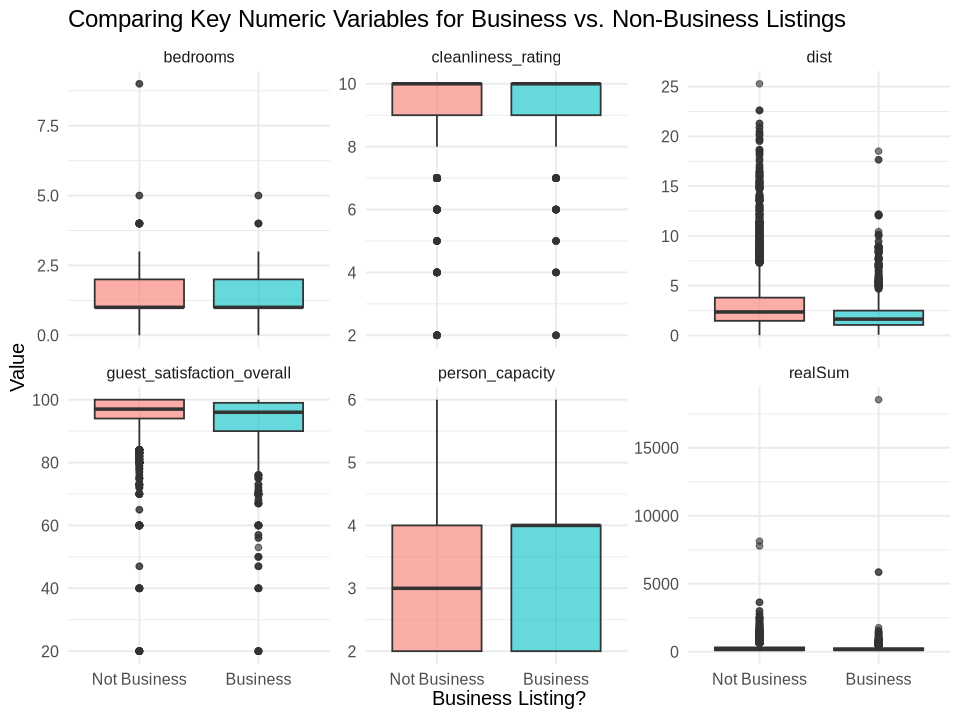

In [5]:
dat_long <- dat_clean %>%
  select(
    biz, realSum, cleanliness_rating, guest_satisfaction_overall,
    bedrooms, person_capacity, dist
  ) %>%
  pivot_longer(
    cols      = c(realSum, cleanliness_rating, guest_satisfaction_overall,
                  bedrooms, person_capacity, dist),
    names_to  = "Variable",
    values_to = "Value"
  )

ggplot(dat_long, aes(x = biz, y = Value, fill = biz)) +
  geom_boxplot(alpha = 0.6) +
  facet_wrap(~ Variable, scales = "free_y") +
  labs(
    title = "Comparing Key Numeric Variables for Business vs. Non-Business Listings",
    x     = "Business Listing?",
    y     = "Value"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")


**Interpretation of the Plot**

From the side‐by‐side boxplots, we observe:

1. **Price (`realSum`)**: Business and Non-Business listings appear to have a similar prices, with outliers extending to higher values.
2. **Cleanliness & Satisfaction**: Both business and non‐business listings show similarly high cleanliness ratings (around 8–10), and guest satisfaction typically exceeds 80, suggesting little difference there.
3. **Bedrooms & Capacity**: Business listings can accommodate slightly larger groups on average, although the number of bedrooms are similar.
4. **Distance (`dist`)**: Non‐business listings sometimes extend farther from the city center, but both groups feature extreme outliers at higher distances.

Overall, the plot highlights a few subtle differences—particularly in price and capacity—while also showing potential skew (especially in `realSum` and `dist`) that may need attention in subsequent modeling steps.


---

**Scatterplot of Distance vs. Guest Satisfaction by `biz`**  
This helps us see if satisfaction declines with distance and whether that relationship differs by listing type.



`geom_smooth()` using formula = 'y ~ x'


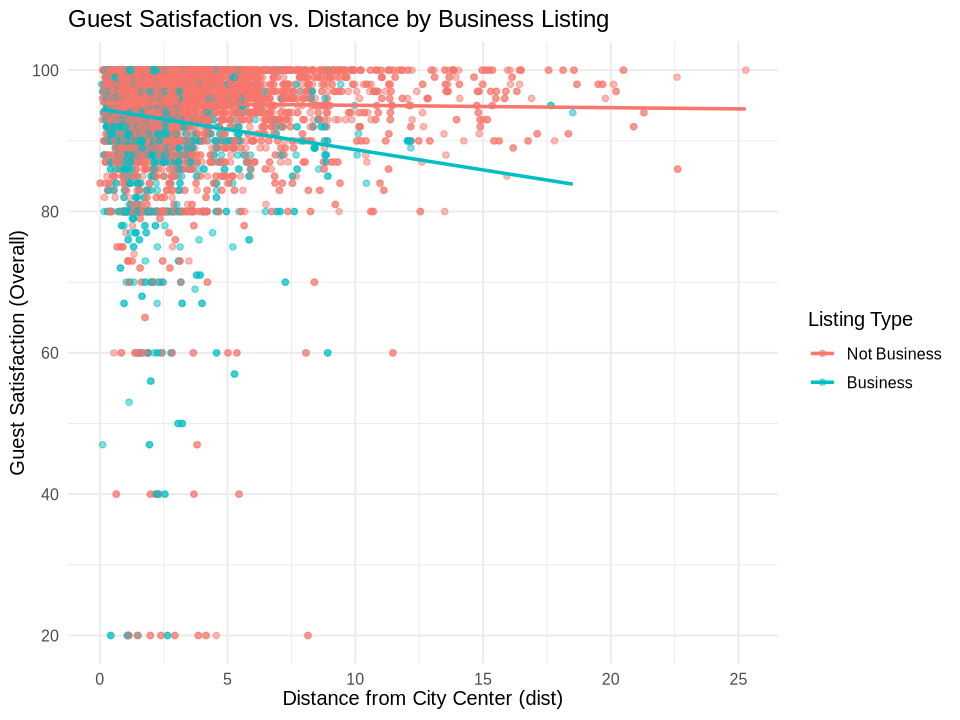

In [6]:
ggplot(dat_clean, aes(x = dist, y = guest_satisfaction_overall, color = biz)) +
  geom_point(alpha = 0.5) +
  geom_smooth(aes(color = biz), method = "lm", se = FALSE) +
  labs(
    title  = "Guest Satisfaction vs. Distance by Business Listing",
    x      = "Distance from City Center (dist)",
    y      = "Guest Satisfaction (Overall)",
    color  = "Listing Type"
  ) +
  theme_minimal(base_size = 12)


**Interpretation**  
- **Immediate Comparison**: You can see if the *slope* or *level* of guest satisfaction differs with increasing distance for business listings versus non‐business ones.  
- **Outliers & Trends**: The scatter highlights any unusually distant or low-satisfaction listings, while the trend lines quickly reveal that the Business group’s satisfaction tends to drop off faster with distance.  
- **Modeling Insight**: We notice a strong difference in how satisfaction relates to the distance for business vs. non‐business listings, suggesting that `dist` may be an important predictor in a logistic model for `biz`.

### Checking for Multicollinearity (VIF)

Before proceeding to LASSO logistic regression, it’s often useful to assess whether any **explanatory variables** are highly collinear. Although LASSO can handle collinearity by shrinking coefficients, a preliminary check can highlight potential problems or redundant features. We use the Variance Inflation Factor (**VIF**), where a value exceeding ~10 commonly indicates problematic collinearity.

In [7]:
# Since VIF is typically calculated from a linear model, we create a temporary
# linear model that includes the numeric version of 'biz' as the response.
# This approach helps approximate collinearity among predictors.
# Alternatively, you could transform or drop some variables if needed.

# 1) Convert 'biz' to numeric
dat_clean_numeric <- dat_clean %>%
  mutate(biz_num = ifelse(biz == "Business", 1, 0))

# 2) Fit a linear model (for collinearity check only)
#    Exclude the factor response 'biz' to avoid duplication
vif_model <- lm(biz_num ~ . - biz, data = dat_clean_numeric)

# 3) Compute VIF for all predictors
vif_values <- vif(vif_model)
vif_values

GVIF      Df GVIF^(1/(2*Df))
realSum                     1.543407 1  1.242339       
room_private                1.627564 1  1.275760       
person_capacity             1.877340 1  1.370161       
host_is_superhost           1.130752 1  1.063368       
multi                       1.021723 1  1.010803       
cleanliness_rating          1.980937 1  1.407458       
guest_satisfaction_overall  1.960059 1  1.400021       
bedrooms                    1.602340 1  1.265836       
dist                        2.902394 1  1.703642       
metro_dist                  1.568689 1  1.252473       
attr_index                  8.045749 1  2.836503       
attr_index_norm            10.827559 1  3.290526       
rest_index                  4.304895 1  2.074824       
rest_index_norm             6.439419 1  2.537601       
city                       11.565481 2  1.844127       
weekend                     1.185113 1  1.088629

**Interpretation of VIF Results**

From the table, most variables display **Variance Inflation Factors (VIFs)** comfortably below 10, suggesting they are not excessively collinear. However, we see that:

- **`city`** has a VIF of about **11.56**, surpassing the usual threshold of 10. This implies that the factor `city` is substantially correlated with other predictors (for instance, certain distance metrics or rating indices may differ strongly by city).  
- **`attr_index_norm`** also falls just over 10, suggesting possible overlap with `attr_index` or other rating variables.  

These elevated VIFs highlight **multicollinearity** concerns for `city` and `attr_index_norm`. While LASSO can mitigate some collinearity by shrinking coefficients, the model may still benefit from either **omitting** or **re‐encoding** these features if they undermine interpretability. Therefore, we will remove those variables before performing LASSO Logistic Regression.

In [8]:
# 1) Create a new model that excludes 'city' and 'attr_index_norm'
vif_model2 <- lm(
  biz_num ~ . - biz - city - attr_index_norm, 
  data = dat_clean_numeric
)

# 2) Compute VIF values again
vif_values2 <- vif(vif_model2)
vif_values2

dat_clean <- select(dat_clean, -city, -attr_index_norm)
head(dat_clean)

realSum               room_private 
                  1.279045                   1.449197 
           person_capacity          host_is_superhost 
                  1.777694                   1.121879 
                     multi         cleanliness_rating 
                  1.019432                   1.969390 
guest_satisfaction_overall                   bedrooms 
                  1.953330                   1.579963 
                      dist                 metro_dist 
                  1.955358                   1.451133 
                attr_index                 rest_index 
                  2.824390                   3.145901 
           rest_index_norm                    weekend 
                  2.012664                   1.060571

realSum  room_private person_capacity host_is_superhost multi biz         
1 194.0337 True         2               False             1     Not Business
2 344.2458 True         4               False             0     Not Business
3 264.1014 True         2               False             0     Business    
4 433.5294 True         4               False             0     Business    
5 485.5529 True         2               True              0     Not Business
6 552.8086 True         3               False             0     Not Business
  cleanliness_rating guest_satisfaction_overall bedrooms dist      metro_dist
1 10                  93                        1        5.0229638 2.5393800 
2  8                  85                        1        0.4883893 0.2394039 
3  9                  87                        1        5.7483119 3.6516213 
4  9                  90                        2        0.3848620 0.4398761 
5 10                  98                        1        0.5447382 0.3186926 
6  8                 100                        2        2.1314201 1.9046682 
  attr_index rest_index rest_index_norm weekend
1  78.69038   98.25390   6.846473       No     
2 631.17638  837.28076  58.342928       No     
3  75.27588   95.38695   6.646700       No     
4 493.27253  875.03310  60.973565       No     
5 552.83032  815.30574  56.811677       No     
6 174.78896  225.20166  15.692376       No

### Methods: Plan
Method: Logistic Regression

This method is appropriate in our case since the response variable is biz, which is a variable with value 1 and 0, in other words, true or false. So this classification problem is suitable with a binomial model (logistic regression).

**Assumptions:**

1.  The response variable has two outcomes (which we already mentioned was true)
2.  Each observation is independent
3.  The variance in binomial is known to be np(1-p), and so the variability is highest when p=0.5
4.  The logit is a linear function of the predictor variables
   
**Limitation & Weakness:**
1.  The relationship between response and predictor might not be linear
2.  If “bad” predictors are selected, it might result in a poor performance

---

In this section, we outline the steps for conducting our **LASSO Logistic Regression** approach from start to finish:

1. **Data Splitting**: We create training and testing subsets to evaluate our final model’s predictive performance.  
2. **Model Matrix Construction**: Instead of manually encoding categorical variables, we rely on `model.matrix()` to produce a design matrix of features. We remove the intercept column since `glmnet()` handles the intercept internally.  
3. **Response Extraction**: We ensure our response variable (`biz`, coded as 0/1) is in matrix form for `glmnet`.  
4. **Fitting the LASSO Model**: Using `glmnet(x, y, alpha=1, family="binomial")`, we fit a **penalized logistic regression**. The LASSO penalty (alpha=1) shrinks some coefficients to zero, effectively performing **feature selection**.  
5. **Model Assessment**: We’ll tune the regularization parameter (`lambda`) via cross‐validation (`cv.glmnet`), selecting the model that optimizes our chosen metric (e.g., deviance, AUC).  
6. **Interpretation**: We interpret the **non‐zero** coefficients as the most influential predictors of whether a listing is for business.  

In [9]:
#-----------------------------------------------------
# 1) Data Splitting: Train/Test
#-----------------------------------------------------
set.seed(123)  # for reproducibility
n_total <- nrow(dat_clean)
train_indices <- sample(seq_len(n_total), size = 0.8 * n_total)

# Create training and testing subsets
dat_train <- dat_clean[train_indices, ]
dat_test  <- dat_clean[-train_indices, ]

#-----------------------------------------------------
# 2) Prepare 'biz' as numeric in both sets
#-----------------------------------------------------
dat_train_numeric <- dat_train %>%
  mutate(biz_num = ifelse(biz == "Business", 1, 0))

dat_test_numeric <- dat_test %>%
  mutate(biz_num = ifelse(biz == "Business", 1, 0))

#-----------------------------------------------------
# 3) Create Model Matrices and Response
#-----------------------------------------------------
# For training
model_matrix_X_train <- model.matrix(
  biz_num ~ . - biz, 
  data = dat_train_numeric
)[, -1]  # remove the (Intercept) column

matrix_Y_train <- as.matrix(dat_train_numeric$biz_num, ncol = 1)

# For testing
model_matrix_X_test <- model.matrix(
  biz_num ~ . - biz, 
  data = dat_test_numeric
)[, -1]  # remove the (Intercept) column

matrix_Y_test <- as.matrix(dat_test_numeric$biz_num, ncol = 1)

# Optional: Quick check of dimensions
dim(model_matrix_X_train)
dim(matrix_Y_train)
dim(model_matrix_X_test)
dim(matrix_Y_test)

[1] 7875   14

[1] 7875    1

[1] 1969   14

[1] 1969    1

**Code Explanation**  
1. *Train/Test Split*: We randomly select 80% of rows for training (`dat_train`), leaving 20% for testing (`dat_test`).  
2. *Numeric Conversion*: We create a new column `biz_num` in both subsets, ensuring `biz` is mapped to 0 or 1.  
3. *Model Matrix*: Using `model.matrix()` on `biz_num ~ . - biz` automatically encodes all relevant predictors (and dummies for factors). We remove the `(Intercept)` column (the first column) because `glmnet` automatically handles the intercept.  
4. *Response Matrices*: The objects `matrix_Y_train` and `matrix_Y_test` each store the corresponding binary outcome (0/1) for training and testing, respectively, in a **matrix** format required by `glmnet`.   

This setup ensures **reproducibility** and **robust** performance estimation.


### (4) Finding the Optimal `lambda` via Cross-Validation

To identify the regularization parameter (`lambda`) that maximizes predictive performance (in terms of **AUC**), we apply 5‐fold cross‐validation on our LASSO logistic model using `cv.glmnet()`. The code snippet below shows how we specify `alpha = 1` (LASSO penalty), `family = "binomial"` for logistic regression, and `type.measure = "auc"` to maximize the **Area Under the ROC Curve**.



In [10]:
library(glmnet)

# Perform 5-fold cross-validation using LASSO (alpha=1)
biz_cv_lambda_LASSO <- cv.glmnet(
  x           = model_matrix_X_train,
  y           = matrix_Y_train,
  alpha       = 1,            # LASSO penalty
  family      = "binomial",   # logistic regression
  type.measure= "auc",        # maximize AUC
  nfolds      = 5             # 5-fold CV
)

# Inspect the CV results
biz_cv_lambda_LASSO



Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure       SE Nonzero
min 0.000117    79  0.8552 0.002126      14
1se 0.007701    34  0.8532 0.002543      11

**Explanation**  
1. **`alpha=1`** selects the LASSO penalty, which encourages sparse solutions by forcing some coefficients to zero.  
2. **`type.measure="auc"`** directs the cross-validation to optimize **AUC** rather than MSE or deviance.  
3. **`nfolds=5`** splits the training data into 5 folds for repeated estimation, producing an average AUC across folds for each candidate `lambda`.  
4. The output of `biz_cv_lambda_LASSO` displays the optimal `lambda` value that maximizes AUC (`lambda.1se` or `lambda.min`) and the cross-validated performance.  

We will use the resulting `biz_cv_lambda_LASSO$lambda.min` (the lambda that yields the highest mean cross-validated AUC) or `biz_cv_lambda_LASSO$lambda.1se` (the most regularized model within 1 standard error of the best AUC) for our final LASSO logistic model.


### (5) Selecting `lambda` and Extracting the LASSO Model

After running `cv.glmnet()` to maximize AUC, we use **`lambda.1se`** as our chosen level of regularization. Below, we:

1. **Plot** the cross-validation results to see how AUC varies with different `lambda` values.
2. **Extract** the best `lambda` within 1 standard error of the minimum (`lambda.1se`).
3. **Refit** the LASSO logistic regression using that chosen `lambda` for final coefficient estimates.



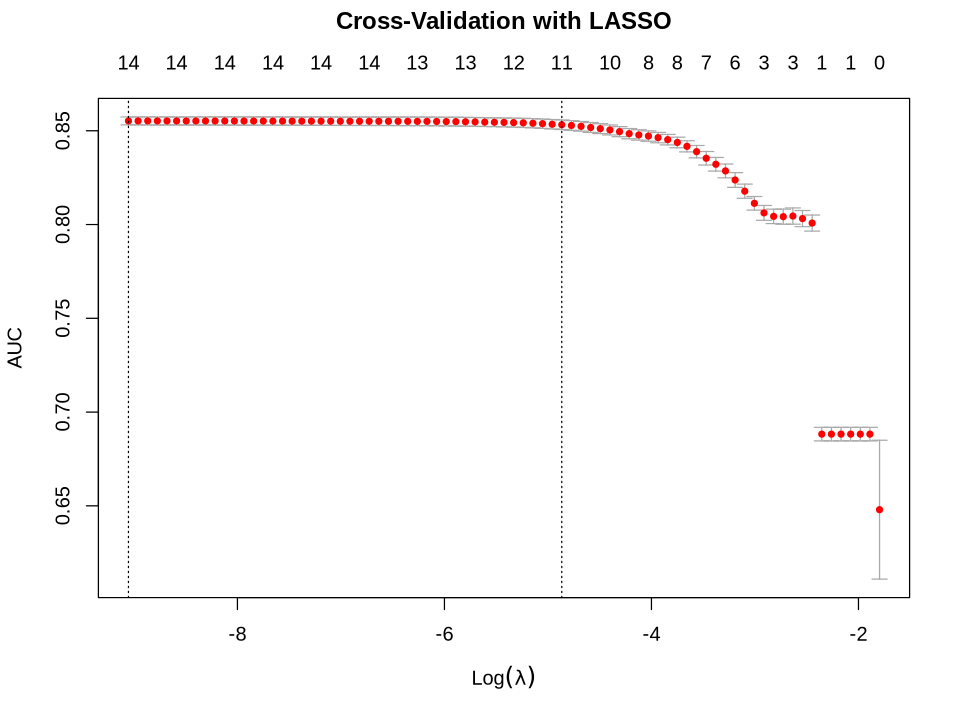

In [11]:
# 1) Visualize the CV results
plot(biz_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

In [12]:
# 2) Identify lambda_1se
lambda_1se_AUC_LASSO <- round(biz_cv_lambda_LASSO$lambda.1se, 4)
lambda_1se_AUC_LASSO

# 3) Fit the final LASSO model at lambda_1se
biz_LASSO_1se_AUC <- glmnet(
  x      = model_matrix_X_train,
  y      = matrix_Y_train,
  alpha  = 1,             # LASSO
  family = "binomial",
  lambda = lambda_1se_AUC_LASSO
)

coef(biz_LASSO_1se_AUC)

[1] 0.0077

15 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)                 2.539424638
realSum                    -0.001027413
room_privateTrue           -0.074570948
person_capacity             0.400793676
host_is_superhostTrue       .          
multi                      -4.001181970
cleanliness_rating          0.166642584
guest_satisfaction_overall -0.051721438
bedrooms                   -0.432947606
dist                       -0.125120482
metro_dist                 -0.354073377
attr_index                  .          
rest_index                  0.001186871
rest_index_norm            -0.002193707
weekendYes                  .          

**Explanation of the Cross-Validation Plot and Results**

The **x‐axis** represents the **log of the regularization parameter** *(log(λ))*, while the **y‐axis** shows the **mean cross‐validated AUC** (Area Under the ROC Curve) for each candidate λ. Each red circle indicates the **average AUC** across the 5 folds at a specific λ value, with vertical bars showing ±1 standard error.  

Two dotted vertical lines mark:
1. **`lambda.min`**: The λ that yields the **highest** mean AUC.
2. **`lambda.1se`**: The **largest** λ whose AUC is within 1 standard error of the AUC at `lambda.min`.  

Since `lambda.1se` typically represents a simpler model with fewer non‐zero coefficients, it is often preferred for **interpretability** and may generalize better. In the example above, `lambda.1se` ≈ 0.0077, and at this level of regularization, the model still attains a near‐maximal cross‐validated AUC (~0.85). This balance of **performance** (AUC) and **parsimony** (fewer features) is why many choose `lambda.1se` for their final LASSO logistic model. 

**Explanation of the Final LASSO Model Coefficients**

After we select `lambda_1se_AUC_LASSO` and fit our LASSO logistic model, the `coef(biz_LASSO_1se_AUC)` output shows which features have **non‐zero** coefficients. Here:

1. **Zeroed‐Out Coefficients**  
   A dot (`.`) indicates that the LASSO penalty shrank that predictor’s coefficient effectively to **zero**. This feature does not contribute to the model’s prediction and is excluded for interpretability.

2. **Non‐Zero Coefficients**  
   Variables such as `room_privateTrue`, `multi`, or `cleanliness_rating` remain in the model, suggesting they **influence** the odds of a listing being for business. 

3. **Interpretation Caveat**  
   - **Magnitude**: Larger absolute values suggest stronger influence on log‐odds of “business.”  
   - **Sign**: A **positive** sign suggests the predictor raises the probability of business use, vice versa.  

Thus, by applying **`lambda_1se`**, we arrive at a **parsimonious** subset of predictors—only those whose coefficients LASSO deems most predictive remain non‐zero. This helps us identify which features truly matter for classifying Airbnb listings as “Business” vs. “Not Business.”


**Extracting and Reporting the AUC at `lambda.1se`**

In [13]:
# 1) Identify the index of lambda.1se
lambda_1se_idx <- which.min(abs(biz_cv_lambda_LASSO$lambda - biz_cv_lambda_LASSO$lambda.1se))

# 2) Extract AUC at lambda.1se
auc_at_lambda_1se <- biz_cv_lambda_LASSO$cvm[lambda_1se_idx]

# 3) (Optional) Round for readability
auc_at_lambda_1se_rounded <- round(auc_at_lambda_1se, 4)

auc_at_lambda_1se_rounded


[1] 0.8532

**Explanation**  
- `biz_cv_lambda_LASSO$lambda` is the vector of tested λ values. We find which λ is closest to `lambda.1se`.  
- `biz_cv_lambda_LASSO$cvm` contains the **mean cross‐validated AUC** for each corresponding λ.  
- By subsetting `cvm` at `lambda_1se_idx`, we obtain the **AUC** that the model attains at `lambda.1se`.  
- We obtain a value of 0.8532 for the AUC.  


### (6) Predicting on the Test Set and Obtaining the ROC Curve

After finalizing our LASSO model (`biz_LASSO_1se_AUC`) and identifying the best penalty parameter `lambda_1se_AUC_LASSO`, we use it to generate predictions on the **test set**. We then compute an ROC curve and visualize how well the model distinguishes “Business” vs. “Not Business” listings on unseen data.



Setting levels: control = 0, case = 1

Warning message in roc.default(response = matrix_Y_test, predictor = as.numeric(predicted_probs)):
“Deprecated use a matrix as response. Unexpected results may be produced, please pass a vector or factor.”
Setting direction: controls < cases




Call:
roc.default(response = matrix_Y_test, predictor = as.numeric(predicted_probs))

Data: as.numeric(predicted_probs) in 1432 controls (matrix_Y_test 0) < 537 cases (matrix_Y_test 1).
Area under the curve: 0.8471

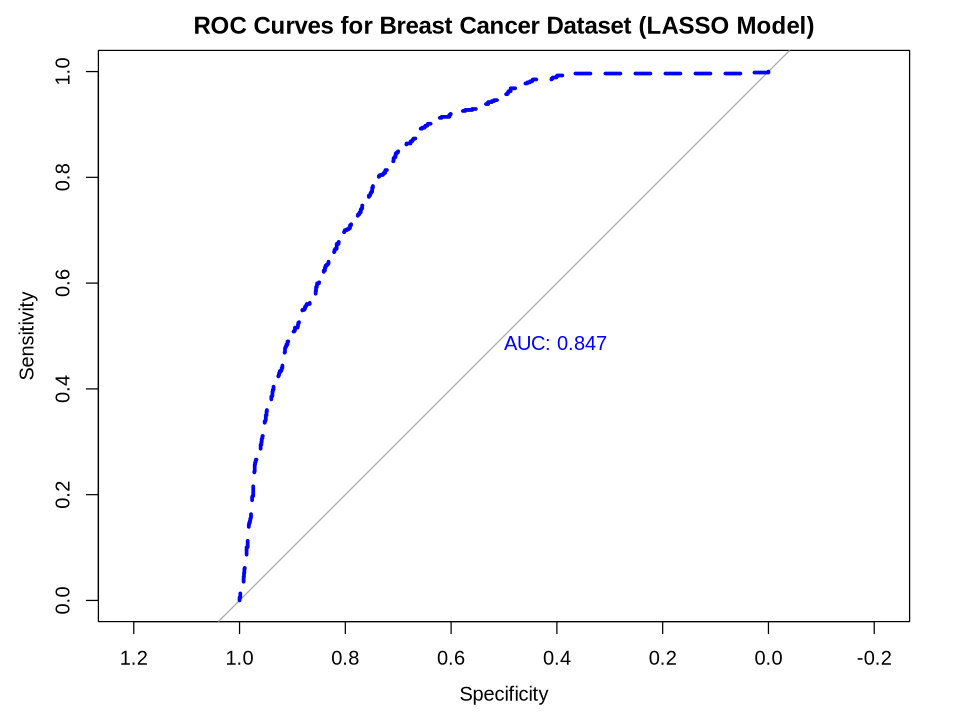

In [14]:
# 1) Generate predicted probabilities (type="response") on the test set
#    We specify 's = lambda_1se_AUC_LASSO' to use the same penalty level 
#    as in our final LASSO model.
predicted_probs <- predict(
  biz_LASSO_1se_AUC, 
  newx = model_matrix_X_test, 
  s    = lambda_1se_AUC_LASSO,
  type = "response"
)

# 2) Build the ROC curve object
ROC_LASSO <- roc(
  response  = matrix_Y_test,               # true labels
  predictor = as.numeric(predicted_probs)  # predicted probabilities
)

ROC_LASSO

# 3) Plot the ROC curve
plot(
  ROC_LASSO,
  print.auc = TRUE,
  col       = "blue",
  lwd       = 3,
  lty       = 2,
  main      = "ROC Curves for Breast Cancer Dataset (LASSO Model)"
)

**Explanation**  
1. **Predicted Probabilities**: We call `predict(..., type="response")` to get probabilities (0–1) of “Business.” Specifying `s = lambda_1se_AUC_LASSO` ensures we use the correct level of regularization determined by cross-validation.  
2. **ROC Curve**: The `roc()` function (from the **pROC** package) measures how well our model separates positive (Business) from negative (Not Business) cases at various probability thresholds.  
3. **Plot**: The resulting **ROC** visually indicates true‐positive rate vs. false‐positive rate. A larger area under this curve (AUC) suggests stronger classification performance. The final curve in `ROC_LASSO` thus represents the LASSO model’s ability to generalize to the **test** data.


**Explanation of the Final Test‐Set Results**

Our **LASSO logistic model** trained with `lambda_1se_AUC_LASSO` achieves an **AUC of 0.847** on the **test set**, as shown by the blue, dashed ROC curve. This high AUC indicates the model can effectively distinguish cases (e.g., business listings) from non‐cases. By comparison, the **cross‐validation** AUC in the training phase was **~0.8532**, demonstrating that the model retains most of its performance on unseen data (the slight drop is typical when moving from training/CV to a true hold‐out set). Overall, an AUC near 0.86 affirms the LASSO approach successfully identifies the most relevant features and achieves **strong predictive ability** on new observations.


## (3) Discussion

Our LASSO logistic model demonstrated strong performance in classifying Airbnb listings as “Business” vs. “Not Business,” achieving an **AUC of ~0.847** on unseen test data. This indicates that features such as **room type**, **cleanliness rating**, **distance to the city center**, and **price** meaningfully contribute to identifying business‐oriented properties. These findings align with prior research (Jang et al. 2019; Kirchner & Pohl 2024), which highlight the importance of both service quality (cleanliness) and practical considerations (location, capacity) for professional or commercial‐style listings.

Although the results met our expectations of a substantial relationship between listing characteristics and business use, future work could investigate **nonlinear relationships** (e.g., log‐dist) or **interactions** (e.g., price × location). Additional refinements might include more granular host features (e.g., superhost status) or a robust approach to handling outliers. Longer‐term, expanding this study to more European cities or incorporating **time trends** (e.g., seasonality, booking lead times) may provide richer insight into the evolution and drivers of business‐focused Airbnb demand. Overall, our model offers a practical tool for identifying potentially business‐oriented listings, informing hosts, platform operators, and urban policymakers about the factors that shape professional usage on Airbnb.


## (4) References

- As Jang et al. (2019) illustrate, business travelers’ priorities differ from leisure guests, suggesting distinct listing attributes may be relevant for predicting business use.  
- Kirchner and Pohl (2024) add that Airbnb is becoming increasingly commercial, especially in major urban centers, underscoring the timeliness of examining “business‐oriented” listings in Amsterdam, Athens, and Berlin.
- Soni, Arman. (2025) Assignment 2. UBC

Data source: Kaggle (https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities)